In [476]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import DBSCAN
%matplotlib widget

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
diffusion="0.05percent"
# diffusion="nodiff"
# file_id = "1"
file_id = "2638"

if (pressure == 1):
    det_size = 6.182*1e3
elif (pressure == 5):
    det_size = 3.615*1e3
elif (pressure == 10):
    det_size = 2.870*1e3
elif (pressure == 15):
    det_size = 2.507*1e3
elif (pressure == 25):
    det_size = 2.114*1e3


# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")


hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_smear_{file_id}.h5", "MC/hits")

if (diffusion == "nodiff"):
    hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_smear_{file_id}.h5", "MC/hits")
else:
    hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_{diffusion}_smear_{file_id}.h5", "MC/hits")


# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_1bar_nexus_2954.h5", "MC/hits")
# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_2954.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

eid=event_list[14]

data = hits[hits.event_id ==eid]
# data = CutandRedistibuteEnergy(data, 0.0004)

data_true = hits_true[hits_true.event_id == eid]
# data_true["z"] = data_true["z"]-det_size/2.0

# print(hits.event_id.unique())

,event_id,x,y,z,energy
0,321959,-437.957336,-1230.252808,2009.536743,0.000025
1,321959,-383.094147,-1209.948853,2020.749634,0.000050
2,321959,-433.576904,-1134.386108,2024.267090,0.000025
3,321959,-390.726898,-1167.759033,2024.357788,0.000074
4,321959,-370.979614,-1134.344482,2024.456421,0.000025
...,...,...,...,...,...
372508,322032,1487.139893,-1582.079834,533.749512,0.000050
372509,322032,1469.414795,-1566.684570,534.221497,0.000422
372510,322032,1470.067749,-1534.052002,534.249146,0.001017
372511,322032,1507.128174,-1568.410034,534.292114,0.000050


In [477]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

group_sf = 3

mean_sigma = round(group_sf*Diff_smear*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

Diffussion smear is:  2.0 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  4
Radius scale factor is:  7
Hit grouping factor is:  2.1
Tortuosity distance scale is: 175.0
mean_sigma: 98


In [478]:
reco_DE_event = data.copy()

print(len(reco_DE_event))

df_merged = GroupHits(reco_DE_event, mean_sigma)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(df_merged.group_id.unique()) > 10):
    print("Running grouping again new mean sigma is:", mean_sigma*5)
    df_merged = GroupHits(reco_DE_event, mean_sigma*5)

4476


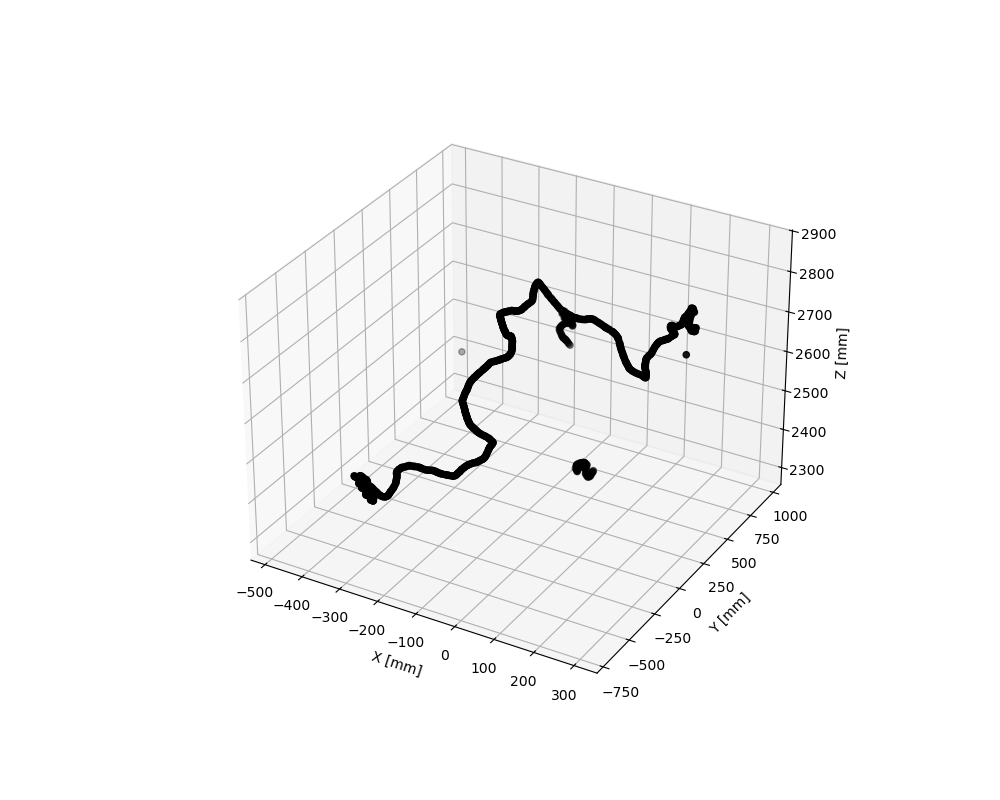

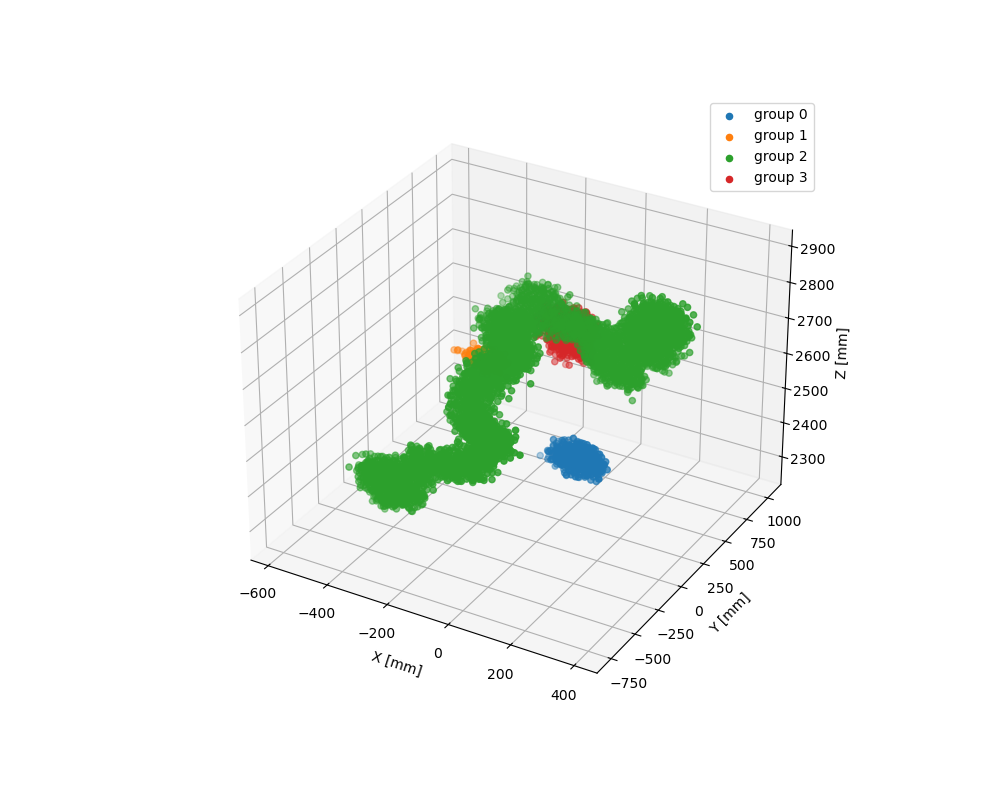

In [479]:

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_true['x'], data_true['y'], data_true['z'],c="k")
# ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

ax1.set_xlabel("X [mm]")
ax1.set_ylabel("Y [mm]")
ax1.set_zlabel("Z [mm]")


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
for gid in sorted(df_merged["group_id"].unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'], label = f"group {gid}")
    # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

    ax1.set_xlabel("X [mm]")
    ax1.set_ylabel("Y [mm]")
    ax1.set_zlabel("Z [mm]")
    ax1.legend()
# plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/GroupedHits.pdf")